# EDA on training data (JW)

In [1]:
import numpy as np
import pandas as pd
import datetime

In [ ]:
train_df = pd.read_csv('assets/input/train.csv')
test_df = pd.read_csv('assets/input/test.csv')
# weather_df = pd.read_csv('west_nile/input/weather.csv', na_values='M')
# spray_df = pd.read_csv('west_nile/input/spray.csv')

In [ ]:
print(train_df.shape)
print(test_df.shape) 
# The test set is an order of magnitude greater because there are, presumably, entries for every trap, species, and day.

In [ ]:
list(train_df.columns)

In [ ]:
print("Unique days in training: ", len(train_df.Date.unique()))
print("Unique traps in training: ", len(train_df.Trap.unique()))
print("Unique species in training: ", len(train_df.Species.unique()))
print(len(train_df.Date.unique()) * len(train_df.Trap.unique())* len(train_df.Species.unique()))

In [ ]:
print("Unique days in test: ", len(test_df.Date.unique()))
print("Unique traps in test: ", len(test_df.Trap.unique()))
print("Unique species in test: ", len(test_df.Species.unique()))
print(len(test_df.Date.unique()) * len(test_df.Trap.unique())* len(test_df.Species.unique()))

In [ ]:
print("In the TRAINING data:\n----------")
for bug in train_df['Species'].unique():
    print("There are {} cases with the mosquito {}".format(train_df['WnvPresent'][train_df['Species']==bug].sum(), bug))

In [ ]:
# print("There are {} nulls in the training set, {} in the test set, {} in the weather set, and {} in the spray set.".format(train_df.isna().sum().sum(),
#                                                                                                                           test_df.isna().sum().sum(),
#                                                                                                                           weather_df.isna().sum().sum(),
#                                                                                                                           spray_df.isna().sum().sum()))
print("There are {} nulls in the training set and {} in the test set.".format(train_df.isna().sum().sum(), test_df.isna().sum().sum()))

## Proposed steps for cleaning: 
1. Turn Date into datetime type
2. Consider the following columns redundant? (Address, Block, Street, Address number and Street, Address Accuracy)
3. Bring in other data to make better use of the location information
4. Transform Latitude and Longitude information into a more useful form (distance to water, neighborhood, distance from other points?) **NOTE: THE LATITUDE AND LONGITUDE INFORMATION IS DERIVED FROM THE ADDRESS INFORMATION ACCORDING TO THE KAGGLE DESCRIPTION**

***These steps will each be implemented as a function, and a general cleaning function will gather them all together.***

In [ ]:
def make_datetime(dataframe, date_col):
    pd.to_datetime(dataframe[date_col])

In [ ]:
%run utilities/my_neighborhood_maker.py

In [ ]:
get_neighborhood_for_point(train_df['Latitude'][0], train_df['Longitude'][0])

In [ ]:
neighborhood_col = []
for i in range(len(train_df['Latitude'])):
    neighborhood_col.append(get_neighborhood_for_point(train_df['Latitude'][i], train_df['Longitude'][i]))

In [ ]:
len(neighborhood_col), train_df.shape[0]

In [ ]:
train_df['neighborhood'] = neighborhood_col

In [ ]:
train_df.head()

In [ ]:
train_df.to_csv("train_with_neighborhoods.csv")

In [ ]:
neighborhood_col = []
for i in range(len(test_df['Latitude'])):
    neighborhood_col.append(get_neighborhood_for_point(test_df['Latitude'][i], test_df['Longitude'][i]))
test_df['neighborhood'] = neighborhood_col

In [ ]:
test_df.to_csv('test_with_neighborhoods.csv')

In [6]:
train_df = pd.read_csv('assets/train_with_neighborhoods.csv', index_col=0)

In [13]:
len(train_df['neighborhood'].unique())

65

In [22]:
total_per_neighborhood_df = train_df.groupby('neighborhood').sum()[['WnvPresent','NumMosquitos']]

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

Text(0.5,1,'Distribution of Wnv Per Neighborhood')

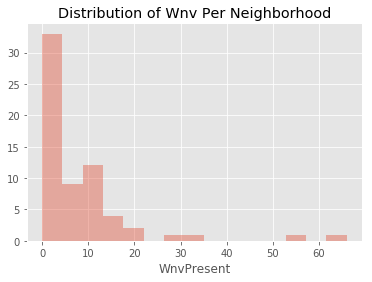

In [35]:
sns.distplot(total_per_neighborhood_df['WnvPresent'], kde = False)
plt.title("Distribution of Wnv Per Neighborhood")

*There are two neighborhoods that have lots of West Nile.*

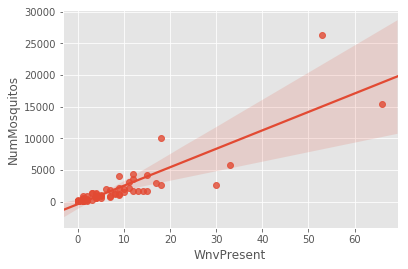

In [36]:
sns.regplot(total_per_neighborhood_df['WnvPresent'], total_per_neighborhood_df['NumMosquitos'])

*Again, this number seems to really stand out for about 5 of the neighborhoods.*

In [37]:
total_per_neighborhood_df.sort_values(by = 'WnvPresent', ascending=False).head(10)

,WnvPresent,NumMosquitos
neighborhood,,
O'Hare,66,15386
South Deering,53,26351
Dunning,33,5759
Norwood Park,30,2614
Calumet Heights,18,10022
New City,18,2676
Humboldt Park,17,2886
"Sauganash,Forest Glen",15,4144
Portage Park,15,1735


*Top 10 neighborhoods by West Nile*

In [38]:
total_per_neighborhood_df.sort_values(by = 'NumMosquitos', ascending=False).head(10)

,WnvPresent,NumMosquitos
neighborhood,,
South Deering,53,26351
O'Hare,66,15386
Calumet Heights,18,10022
Dunning,33,5759
Hegewisch,12,4294
"Sauganash,Forest Glen",15,4144
East Side,9,4079
"Little Italy, UIC",12,3616
Mount Greenwood,11,3168


*Top 10 neighborhoods by NumMosquitos. Notice that South Deering and O'Hare have switched rankings. South Deering has more mosquitos but less virus... could the airport itself be a problem?*

*Also, is Calumet Heights a success story? What about the number of non-disease carrying mosquitos?*

In [41]:
train_df.groupby("Species").sum()[['NumMosquitos','WnvPresent']]

,NumMosquitos,WnvPresent
Species,,
CULEX ERRATICUS,7,0
CULEX PIPIENS,44671,240
CULEX PIPIENS/RESTUANS,66268,262
CULEX RESTUANS,23431,49
CULEX SALINARIUS,145,0
CULEX TARSALIS,7,0
CULEX TERRITANS,510,0


In [51]:
exploratory_df = train_df.groupby(['neighborhood', 'Species']).sum()[['NumMosquitos','WnvPresent']]

In [50]:
train_df[(train_df['WnvPresent'] != 0) & (train_df['Species']=="CULEX PIPIENS/RESTUANS")].shape

(262, 13)

In [52]:
exploratory_df[exploratory_df['WnvPresent'] != 0]

NumMosquitos  WnvPresent
neighborhood          Species                                         
Archer Heights        CULEX PIPIENS                    210           3
                      CULEX PIPIENS/RESTUANS          1392           5
                      CULEX RESTUANS                   548           1
Ashburn               CULEX PIPIENS                    177           3
                      CULEX PIPIENS/RESTUANS          1430           4
                      CULEX RESTUANS                   475           4
Auburn Gresham        CULEX PIPIENS                    255           1
                      CULEX PIPIENS/RESTUANS           795           3
Austin                CULEX PIPIENS                    189           1
                      CULEX PIPIENS/RESTUANS           541           4
                      CULEX RESTUANS                   167           2
Avalon Park           CULEX PIPIENS                     45           1
                      CULEX PIPIENS/RESTUANS           226           1
Avondale              CULEX PIPIENS                     79           2
                      CULEX PIPIENS/RESTUANS           249           1
                      CULEX RESTUANS                   160           1
Belmont Cragin        CULEX PIPIENS                    368           4
                      CULEX PIPIENS/RESTUANS          1133           8
                      CULEX RESTUANS                   176           1
Beverly               CULEX PIPIENS                    456           6
                      CULEX PIPIENS/RESTUANS           906           4
Burnside              CULEX PIPIENS/RESTUANS           618           3
                      CULEX RESTUANS                   469           1
Calumet Heights       CULEX PIPIENS                   7464          14
                      CULEX PIPIENS/RESTUANS          1964           4
Chatham               CULEX PIPIENS/RESTUANS           506           2
Chicago Lawn          CULEX PIPIENS                    370           3
                      CULEX PIPIENS/RESTUANS          1101           3
                      CULEX RESTUANS                   316           1
Clearing              CULEX PIPIENS                    502           7
...                                                    ...         ...
O'Hare                CULEX PIPIENS/RESTUANS          9358          38
                      CULEX RESTUANS                  4221           8
Portage Park          CULEX PIPIENS                    321           6
                      CULEX PIPIENS/RESTUANS          1111           9
Pullman               CULEX PIPIENS                     32           1
Riverdale             CULEX PIPIENS/RESTUANS            75           1
Roseland              CULEX PIPIENS                     35           1
Sauganash,Forest Glen CULEX PIPIENS                    718           7
                      CULEX PIPIENS/RESTUANS          2209           7
                      CULEX RESTUANS                  1215           1
South Chicago         CULEX PIPIENS                    452           3
South Deering         CULEX PIPIENS                  17713          37
                      CULEX PIPIENS/RESTUANS          7445          15
                      CULEX RESTUANS                  1114           1
South Shore           CULEX PIPIENS/RESTUANS           204           1
Ukrainian Village     CULEX PIPIENS                     70           1
                      CULEX PIPIENS/RESTUANS           412           1
                      CULEX RESTUANS                   181           2
Washington Heights    CULEX PIPIENS                    128           2
                      CULEX PIPIENS/RESTUANS           305           2
                      CULEX RESTUANS                   123           1
West Ridge            CULEX PIPIENS                    253           5
                      CULEX PIPIENS/RESTUANS           564           3
                      CULEX RESTUANS                   409           1

Schubert's part

In [ ]:
import pandas as pd 
import seaborn as sns 
import math 
import datetime

In [ ]:
def clean_code(data):
    pass

In [ ]:
def create_features(data):
    pass